In [32]:
# Import
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_squared_error
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestClassifier

In [33]:
# Load the Dataset
df = pd.read_csv("dmu-work/transformers-final-reduit.csv")

In [34]:
print(df.isnull().sum())

version           0
path              0
file_type         0
line_count        0
method_count      0
coupling_score    0
has_smell         0
dtype: int64


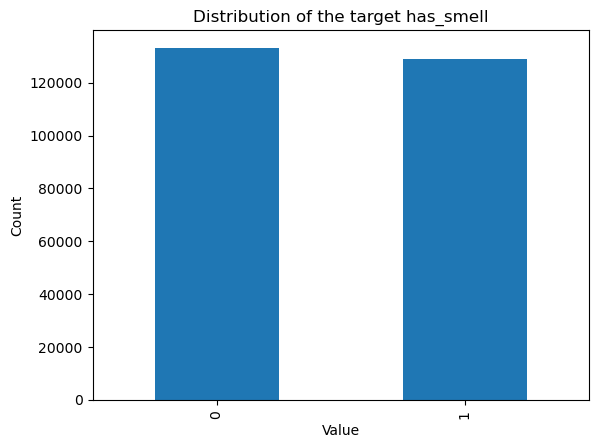

In [35]:
df["has_smell"].value_counts().plot(kind="bar")
plt.title("Distribution of the target has_smell")
plt.xlabel("Value")
plt.ylabel("Count")
plt.show()

In [36]:
# Encoding categorical data
categorical_features = ["version", "path", "file_type"]
numerical_features = ["line_count", "method_count", "coupling_score"]
target_feature = "has_smell"

# Preprocessing
onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_cat = onehot_encoder.fit_transform(df[categorical_features])

X_num = df[numerical_features].values

X_combined = np.concatenate([X_cat, X_num], axis=1)
y = df[target_feature].values

In [37]:
# Splitting the dataset into the Training set and the Test set
split_idx = int(0.8 * len(df))
X_train, X_test = X_combined[:split_idx], X_combined[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

In [38]:
# Feature scaling
num_start = X_cat.shape[1]
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# ANN Model

In [40]:
ann_model = tf.keras.models.Sequential()
ann_model.add(tf.keras.layers.Dense(units=64, activation='relu'))
ann_model.add(tf.keras.layers.Dropout(0.3))
ann_model.add(tf.keras.layers.Dense(units=32, activation='relu'))
ann_model.add(tf.keras.layers.Dropout(0.3))
ann_model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

In [41]:
ann_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
ann_model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=32, callbacks=[callback])

Epoch 1/100
5248/5248 [==============================] - 23s 4ms/step - loss: 0.1283 - accuracy: 0.9469 - val_loss: 0.6910 - val_accuracy: 0.8721
Epoch 2/100
5248/5248 [==============================] - 19s 4ms/step - loss: 0.0451 - accuracy: 0.9810 - val_loss: 0.8779 - val_accuracy: 0.8732
Epoch 3/100
5248/5248 [==============================] - 19s 4ms/step - loss: 0.0305 - accuracy: 0.9870 - val_loss: 1.1724 - val_accuracy: 0.8788
Epoch 4/100
5248/5248 [==============================] - 20s 4ms/step - loss: 0.0219 - accuracy: 0.9911 - val_loss: 1.5352 - val_accuracy: 0.8745
Epoch 5/100
5248/5248 [==============================] - 19s 4ms/step - loss: 0.0168 - accuracy: 0.9933 - val_loss: 1.6812 - val_accuracy: 0.8754
Epoch 6/100
5248/5248 [==============================] - 19s 4ms/step - loss: 0.0122 - accuracy: 0.9952 - val_loss: 2.0514 - val_accuracy: 0.8787
Epoch 7/100
5248/5248 [==============================] - 19s 4ms/step - loss: 0.0093 - accuracy: 0.9964 - val_loss: 2.0916 -

In [43]:
y_pred_ann = (ann_model.predict(X_test) > 0.5).astype(int).flatten()
print("Accuracy:", accuracy_score(y_test, y_pred_ann))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_ann))
print("Classification Report:\n", classification_report(y_test, y_pred_ann))

1640/1640 [==============================] - 2s 1ms/step
Accuracy: 0.8917136758652233
Confusion Matrix:
 [[23094   326]
 [ 5356 23696]]
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.99      0.89     23420
           1       0.99      0.82      0.89     29052

    accuracy                           0.89     52472
   macro avg       0.90      0.90      0.89     52472
weighted avg       0.91      0.89      0.89     52472



# Random Forest Model

In [45]:
forest_model = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
forest_model.fit(X_train, y_train)
y_pred_forest = forest_model.predict(X_test)

In [46]:
print("Accuracy:", accuracy_score(y_test, y_pred_forest))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_forest))
print("Classification Report:\n", classification_report(y_test, y_pred_forest))

Accuracy: 0.9040821771611526
Confusion Matrix:
 [[23124   296]
 [ 4737 24315]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.99      0.90     23420
           1       0.99      0.84      0.91     29052

    accuracy                           0.90     52472
   macro avg       0.91      0.91      0.90     52472
weighted avg       0.92      0.90      0.90     52472



# Code Stacking (SVR)

In [48]:
# Créer les ebtrées du modèle d'ensemble (stacking)
ann_preds = ann_model.predict(X_test).flatten()
forest_preds = forest_model.predict(X_test)
stacked_inputs = np.column_stack((ann_preds, forest_preds))

1640/1640 [==============================] - 2s 1ms/step


In [49]:
# Entrîner le modèle méta (SVR)
meta_model = SVR()
meta_model.fit(stacked_inputs, y_test)

SVR()

In [50]:
# Prédictions finales
final_preds = meta_model.predict(stacked_inputs)

In [51]:
# Evaluation
mse = mean_squared_error(y_test, final_preds)
print("MSE du modèle de stacking (SVR):", mse)
print("Prédictions (extrait):", final_preds[:10])

MSE du modèle de stacking (SVR): 0.05178959566589187
Prédictions (extrait): [0.09994844 0.90014426 0.90048149 0.10012779 0.09997209 0.90035247
 0.89996699 0.09993123 0.90047689 0.09992857]


In [52]:
final_preds_binary = (final_preds >= 0.5).astype(int)

# Accuracy
accuracy = accuracy_score(y_test, final_preds_binary)
print("Accuracy stacking SVR :", accuracy)

# Evaluation complète
print("Confusing Maxtric:\n", confusion_matrix(y_test, final_preds_binary))
print("Classification Report:\n", classification_report(y_test, final_preds_binary))

Accuracy stacking SVR : 0.942273974691264
Confusing Maxtric:
 [[22848   572]
 [ 2457 26595]]
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.98      0.94     23420
           1       0.98      0.92      0.95     29052

    accuracy                           0.94     52472
   macro avg       0.94      0.95      0.94     52472
weighted avg       0.95      0.94      0.94     52472

